# CA2 - ML on Agriculture in Ireland and EU

## Overview

In this notebook, ML techniques were applied on datasets related to the agriculture topic.

In the first part of the notebook, it was performed a sentiment analysis on a set of tweets collected about agriculture and food prices.

The tweets were processed to extract their sentiment and NLP methods were applied to prepare the data for classification methods.

In the second part of this notebook, the following datasets were studied:

    - Dataset 1
    - Dataset 2

For Dataset 1 it was applied X, Y, Z techniques to classify/predict bla.

## Auxiliary Functions

In this section, the auxiliary classes and functions used in this notebook were implemented.

<b>User can skip the Twitter's Online Data Collection step to avoid using Twitter's API and use the previously collected dataset.</b>

The following requirements should be satisfied before running the code in this notebook:

* Instructions to perform the sentiment analysis:

    - NLTK library should be installed: The code to install this lib is commented out in the code below.


* Instructions to use the Twitter API:

    - User should have an account on <a href="https://developer.twitter.com/https://developer.twitter.com/">Twitter's Developer Portal</a> to obtain their own access keys and tokens.
    
    - The required access level to run the commands in this notebook is 'Essential'.
    
    - There should exist a file called .twitter_env in the machine's home directory with the following API user keys:

        ```
        API_KEY=***
        API_KEY_SECRET=***
        BEARER_TOKEN=***
        ```

### Imports and Constants Definition

The imports and constantes used in this project are defined in this section.

User can uncomment the commands to install any missing package.

In [411]:
# uncomment to install any missing lib
# !pip install wordcloud
# !pip install textblob
# !pip install punkt
# !pip install python-dotenv
# import nltk
# nltk.download()

# importing libs
from dotenv import dotenv_values
from pathlib import Path
from os import listdir
from os.path import isfile, join, abspath
import os
import re
import json
import string
import logging
import warnings
import requests
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from wordcloud import WordCloud
from textblob import TextBlob 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# ignore warnings
warnings.filterwarnings('ignore')

# use a logger to help debugging
logger = logging.getLogger('mylogger')
# set logger level
logger.setLevel(logging.ERROR)

# path to the current directory
CURR_PATH = abspath(os.getcwd())
# path to the users directory
HOME_DIR = str(Path.home())
# path to dataset dir
DATASET_DIR = join(CURR_PATH, 'datasets')
# path to store collected tweets
TWEETS_DIR = join(DATASET_DIR, 'tweets_online')

# twitter csv data file
TWITTER_DF_FILE = 'tweets_df'

# twitter env file
TWITTER_ENV_FILE = '.twitter_env'

# list of sentiment labels
sentiment_lst = ['negative', 'neutral', 'positive']

### Auxiliary Classes

The classes below were implemented to process the Twitter's requests, JSON files and to apply text processing.

The idea was to modulatize the code, keeping each function to its own class, which improves code readability, maintainability and reuse.

In [418]:
class HttpConnect:
    """
    This base class represents any Http connection.
    
    Attributes:
        config  (dict): Dict with the config parameters for authentication.
    """
    config = None

    def __init__(self, config):
        """
        The constructor for HttpConnect class.
  
        Parameters:
            config  (dict): Dict with the config parameters for authentication.
        """
        self.config = config

    def get_bearer_auth(self, r):
        """
        Method required by bearer token authentication.
        
        Parameters:
            r (dict): Dict with required parameters for Bearer auth.
        """
        if self.config is None:
            raise Exception('Unable to create Bearer authorization object.')

        r.headers['Authorization'] = f"Bearer { self.config['BEARER_TOKEN'] }"
        r.headers['User-Agent'] = 'v2RecentSearchPython'

        return r

    def connect_endpoint(self, url, params_dict={}):
        """
        This method connects to the endpoint given by the input.
        
        Parameters:
            url          (str): String with the request url.
            params_dict (dict): Dict with endpoint parames.
        """
        response = requests.get(url, auth=self.get_bearer_auth, params=params_dict)

        if response is None:
            raise Exception('Invalid response.')

        logger.info(response.status_code)

        if response.status_code != 200:
            raise Exception(response.status_code, response.text)

        return response.json()

class TwitterApi(HttpConnect):
    """
    This class handles the Twitter API requests.
    
    Attributes:
        config  (dict): Dict with the config parameters for authentication.
    """
    # twitter recent search api url
    TWITTER_API_SEARCH_URL = 'https://api.twitter.com/2/tweets/search/recent'

    last_response = None
    config = None

    def __init__(self, config):
        """
        The constructor for TwitterApi class.

        Parameters:
            config  (dict): Dict with the config parameters for authentication.
        """
        HttpConnect.__init__(self, config)

    def search_tweets(self, params={}, max_pages=10):
        """
        This method uses Twitter's API to search for recent tweets based on the input query.

        Parameters:
            params   (dict): Twitter's recent search API params.
            max_pages (int): Max pages to go over in case of result pagination.
        Returns:
            tweets_list (lst): List of retrieved tweets.
        """        
        tweets_list = []
        if self.run_request(self.TWITTER_API_SEARCH_URL, params):
            tweets_list, next_token = self.extract_tweets()
            count=1

            if next_token is not None and count < max_pages:
                url = f'{ self.TWITTER_API_SEARCH_URL }?next_token={next_token}'
                if self.run_request(url, params):
                    next_tweets_list, next_token = self.extract_tweets()
                    tweets_list+= next_tweets_list
                    count+=1
                else:
                    next_token = None

        print(f"{ len(tweets_list) } tweets retrieved!")

        return tweets_list
    
    def run_request(self, url, params={}):
        """
        Auxiliary method to perform the request.

        Parameters:
            url     (str): String with the request url.
            params (dict): Twitter's API params.
        Returns:
            ret (bol): True if request returned successfully, False otherwise.
        """         
        ret = False
        try:
            self.last_response = self.connect_endpoint(url, params)
            ret = True
        except Exception as e:
            logger.error(e)
        return ret

    def parse_response(self):
        """
        Auxiliary method to parse the response.

        Returns:
            meta (dict), data (lst): Dict with the metadata and list with the requested data.
        """ 
        resp = self.last_response        

        meta = None
        if 'meta' in resp.keys():
            meta = resp['meta']
        
        data = None
        if 'data' in resp.keys():
            data = resp['data']

        return meta, data

    def extract_tweets(self):
        """
        Auxiliary method to extract the returned tweets and next token to continue the iteration, if any.

        Returns:
            tweets_list (lst), next_token (str): List of retrieved tweets, next token for further tweets.
        """         
        meta, data = self.parse_response()
        
        if meta is None or data is None:
            return [], None
        
        tweets_set = set()
        for t in data:
            tweets_set.add(t['text'])

        tweets_list = list(tweets_set)
        next_token = None
        if 'next_token' in meta.keys():
            next_token = meta['next_token']

        return tweets_list, next_token
        
    def save_result_to_file(self, outfile):
        """
        Auxiliary method to save the response into a file.

        Parameters:
            outfile (str): Full file path.
        """  
        json_helper = JsonHelper(self.last_response)
        json_helper.to_file(outfile)

class JsonHelper:
    """
    This class handles JSON data types.
    
    Attributes:
        json_data  (dict): Dictionary to be manipulated as JSON.
    """
    json_data = {}
    
    def __init__(self, json_data):
        """
        The constructor for JsonHelper class.

        Parameters:
            json_data (dict): Dictionary to be manipulated as JSON.
        """
        self.json_data = json_data

    def to_file(self, outfile):
        """
        Auxiliary method to save the json into a file.

        Parameters:
            outfile (str): Full file path.
        """
        if len(outfile) == 0:
            logger.warning('Output filename is empty!')
            return

        with open(outfile, 'w', encoding='utf-8') as f:
            json.dump(self.json_data, f, ensure_ascii=False, indent=4)

    def to_string(self):
        """
        Auxiliary method to return the string version of the json data.
        """
        return json.dumps(self.json_data, indent=4, sort_keys=True, ensure_ascii=False)

class TextProcessor:
    """
    Helper class to perform text processing using NLP techniques.
    """
    def __init__(self):
        """
        The constructor for TextProcessor class.
        """
        return

    @staticmethod
    def get_sentiment(text):
        """
        Auxiliary method to extract the sentiment from the input text.

        Parameters:
            text (str): String to be processed.
        Returns:
            sentiment (str): negative, positive or neutral value.
        """
        res = TextBlob(text).sentiment.polarity     
        if res < 0:
          return sentiment_lst[0]
        elif res > 0:
          return sentiment_lst[2]
        return sentiment_lst[1]

    @staticmethod
    def process_text(text, use_stemmer=False, use_lemmatizer=False):
        """
        Method responsible to execute all text processing steps.
        
        It converts text to lower case, removes special characters and urls,
        filters out stop words, tokenize and perform stemmer/lemmatizer as per parameters.

        Parameters:
            text       (str): Text to be cleaned.
            use_stemmer    (bol): Flag to indicate if processing should include text stemmer.
            use_lemmatizer (bol): Flag to indicate if processing should include text lemmatizer.
        Returns:
            text (str): Cleaned text.
        """
        text = TextProcessor.clean_text(text)
        tokens = TextProcessor.get_tokens(text)
        filtered_words = TextProcessor.filter_stop_words(tokens)

        if use_stemmer:
            filtered_words = TextProcessor.apply_stemmer(filtered_words)

        if use_lemmatizer:
            filtered_words = TextProcessor.apply_lemmatizer(filtered_words)

        return " ".join(filtered_words)
    
    @staticmethod
    def clean_text(text):
        """
        Auxiliary method to remove special characters, urls and ponctuations from the text.

        Parameters:
            text (str): String to be cleaned.
        Returns:
            text (str): Clened text.
        """
        # convert to lower case
        text = text.lower()
        # remove urls
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        # remove user @ references and '#' from text
        text = re.sub(r'\@\w+|\#','', text)
        # removing special chars
        text = re.sub('[^a-zA-Z]', ' ', text)
        # remove punctuations
        text = text.translate(str.maketrans('', '', string.punctuation))
        return text

    @staticmethod
    def get_tokens(text):
        """
        Auxiliary method to extract a vector of tokens from the input text.

        Parameters:
            text (str): String to be tokenized.
        Returns:
            tokens ([]): Tokenized words.
        """
        return word_tokenize(text)

    @staticmethod
    def filter_stop_words(tokens=[]):
        """
        Auxiliary method to filter out stop words.

        Parameters:
            tokens ([]): String array to be filtered.
        Returns:
            tokens ([]): Filtered words.
        """
        stop_words = set(stopwords.words('english'))
        filtered_words = [w for w in tokens if not w in stop_words]
        return filtered_words

    @staticmethod
    def apply_stemmer(tokens=[]):
        """
        Auxiliary method to apply Porter Stemmer to the tokens list.

        Parameters:
            tokens ([]): String array to be processed.
        Returns:
            stemmed_words ([]): Stemmed words.
        """
        ps = PorterStemmer()
        stemmed_words = [ps.stem(w) for w in tokens]
        return stemmed_words

    @staticmethod
    def apply_lemmatizer(tokens=[], part_of_speech='a'):
        """
        Auxiliary method to apply Word Net Lemmatizer to the tokens list.

        Parameters:
            tokens ([]): String array to be processed.
        Returns:
            lemma_words ([]): Lemmatized words.
        """
        lemmatizer = WordNetLemmatizer()
        lemma_words = [lemmatizer.lemmatize(w, pos=part_of_speech) for w in tokens]
        return lemma_words

### Auxiliary Functions

In this section, the auxiliary functions were implemented to help modularize the code analysis.

In [419]:
def get_collected_twitter_file_path():
    """
    Auxiliary function to get a valid twitter file name.
    
    It checks if there is a file with the same name and append an index.

    Returns:
        filename (str): Available filename.
    """    
    same_file_list = [f for f in listdir(TWEETS_DIR) if isfile(join(TWEETS_DIR, f)) 
                      and str(f).startswith(TWITTER_DF_FILE) and str(f).endswith('.csv')]
    n_same_file = len(same_file_list)

    suffix = ''
    if n_same_file > 0:
        suffix = f'_{ n_same_file }'

    filename = f'{TWITTER_DF_FILE}{ suffix }.csv'
    return join(TWEETS_PATH, filename)

def get_env_map():
    """
    Auxiliary function to read and parse the environment file for the Twitter API.
    
    It assumes an env file exists in the home dir.

    Returns:
        env (dict): Dictionary with the env parameters.
    """
    env_path = join(HOME_DIR, TWITTER_ENV_FILE)

    if not os.path.exists(env_path):
        logger.error(F'Unable to read the environment file. Make sure a { TWITTER_ENV_FILE } file exists in your home directory.')
        return None

    return dotenv_values(env_path)

def process_tweets(tweets_list):
    """
    Auxiliary method to process the tweets from the input list.
    
    It processes the tweets, extracting their sentiment during the process.
    
    It generates a table with the following columns:

        'tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'
    
    Parameters:
        tweets_list (lst): List of tweets to be processed.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    for i in range(0, len(tweets_list)):
        # raw tweet
        tweet_raw = tweets_list[i]
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)
        
        # cleaned tweet
        tweet_clr = TextProcessor.process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)

        # steemed tweet
        tweet_st = TextProcessor.process_text(tweet_raw, use_stemmer=True)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        # lemmatized tweet
        tweet_lm = TextProcessor.process_text(tweet_raw, use_lemmatizer=True)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def get_freq(df, colname):
    """
    Auxiliary function to calculate the frequency distribution of the words in a column.

    Parameters:
        df (DataFrame): Data frame to be processed.
        colname  (str): Column name to get its frequency calculated.
    Returns:
        fdist    (mtx): Frequency distribution of the tokens.
    """
    tokens_lst = []
    for i in range(0, len(df)):
        text = df.loc[i][colname]
        tokens_lst+= TextProcessor.get_tokens(text)

    fdist = FreqDist(tokens_lst)

    return fdist

def wordcloud_draw(data, color='black'):
    """
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    """
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## Sentiment Analysis

In this section, the Twitter API was used to retrieve recent tweets for the sentiment analysis.

The purpose of this search were to find tweets about inflation or food price, which relate to the agriculture topic.

The limitation of this search is that the subject of the tweets is not necessarily relevant to the agriculture topic.

### Twitter's Online Data Collection

Twitter's API were used to collect recent tweets on the agriculture topic.

The tags used for this search were inflation, food price and agriculture in an attempt to get relevant tweets.

This section can be skipped, in this case, the previously collected data will be used.

In [421]:
# twitter api instance
twitter_api = TwitterApi(get_env_map())

# retrieving tweets according to the query
query_params = {
    'query' : '(inflation OR "food price" OR "agriculture") Europe -is:retweet -has:media lang:en',
    'tweet.fields': 'author_id', 
    'user.fields': 'name',
    'max_results': '100'
}
tweets_list = twitter_api.search_tweets(query_params)

# processing retrieved data using text processing
tweets_df = process_tweets(tweets_list)

# persisting processed dataset
tweets_df.to_csv(get_collected_twitter_file_path())
tweets_df.head()

199 tweets retrieved!


,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,Article summary: https://t.co/rEYEEQqXof (I'm ...,neutral,article summary bot europe inflation,neutral,articl summari bot europ inflat,neutral,article summary bot europe inflation,neutral
1,@irish_news How times have changed. Cross bord...,neutral,times changed cross border interconnectors eur...,neutral,time chang cross border interconnector europ d...,neutral,times changed cross border interconnectors eur...,neutral
2,@Heccles94 @NHSMillion @keepnhspublic @Marchfo...,positive,nobody mentions uk overpopulated england dense...,negative,nobodi mention uk overpopul england dens popul...,positive,nobody mentions uk overpopulated england dense...,negative
3,Most Germans do not expect consumer price grow...,positive,germans expect consumer price growth ease next...,positive,german expect consum price growth eas next yea...,positive,germans expect consumer price growth ease next...,positive
4,The Spanish government announced several measu...,neutral,spanish government announced several measures ...,neutral,spanish govern announc sever measur help peopl...,neutral,spanish government announced several measures ...,neutral


### Data Preparation and Visualization

The twitter's dataset was created using the above Twitter API code. The raw tweets were preserved in the tweet_raw column and new columns were created with the processed data.

The tweet_clr column keeps the tweet after the clean step (removal of special characters, stop words, etc). 

The columns called tweet_st and tweet_lm refer to the tweet text after applying Porter Stemmer and Lemmatizer strategies, respectively on the cleaned tweet.

Each version of the tweet (i.e., tweet_clr, tweet_st and tweet_lm) has its own sentiment calculated, because it was observed that the sentiment algorithm provides different results for each of them. The possible sentiments are: positive, negative and neutral.

This way, the sentiment analysis can be performed on each version of the tweet + sentiment class.

In [422]:
# skip this step if you've run the previous step
tweets_df = pd.read_csv('./datasets/agri_tweets.csv')
tweets_df.head()

,Unnamed: 0,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,0,British public were treated like mugs..lied to...,negative,british public treated like mugs lied sold riv...,neutral,british public treat like mug lie sold river p...,positive,british public treated like mugs lied sold riv...,positive
1,1,EU economies set to contract in 2023 - Financi...,positive,eu economies set contract financial times acco...,positive,eu economi set contract financi time accord ex...,positive,eu economies set contract financial times acco...,positive
2,2,Big big good news for all #Europe and #USA in ...,negative,big big good news europe usa cold season natur...,positive,big big good news europ usa cold season natura...,positive,big big good news europe usa cold season natur...,positive
3,3,"""The measures, coupled with an agreement negot...",positive,measures coupled agreement negotiated european...,positive,measur coupl agreement negoti european union p...,negative,measures coupled agreement negotiated european...,positive
4,4,It was due to the problems of Europe (Covid-19...,positive,due problems europe covid russia ukraine war r...,positive,due problem europ covid russia ukrain war rece...,positive,due problems europe covid russia ukraine war r...,positive


#### Dataset Word Frequency

In order to visualize the data, it was prepared a frequency graph to show the most common words.

For this purpose it was used a tokenizer algorithm to generate tags from all the tweets after the cleanning stage.

The frequency is the same if Stemmer and Lemmatizer steps were applied, so for this graph it was used the cleaned tweet data.

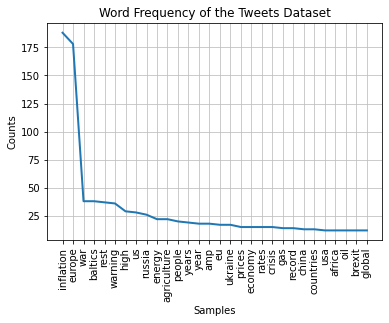

<AxesSubplot:title={'center':'Word Frequency of the Tweets Dataset'}, xlabel='Samples', ylabel='Counts'>

In [425]:
# display the frequency distribution
fdist = get_freq(tweets_df, 'tweet_clr')
fdist.plot(30, cumulative=False, title='Word Frequency of the Tweets Dataset')

#### Dataset Word Cloud

Another way to visualize text datasets is by using word clouds which facilitates the observation of the most frequent words.

It is evident the word 'inflation' is the most common in this dataset.

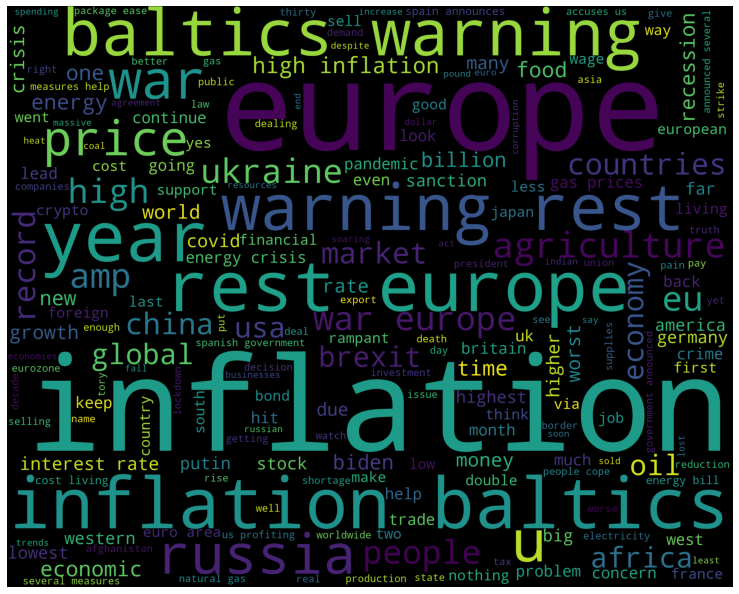

In [334]:
wordcloud_draw(tweets_df['tweet_clr'])

### Naive Bayes Sentiment Classification

In this section, the Naive Bayes classifier is used on the tweets dataset. 

The task being solved is how to predict the sentiment of the tweets based on the text.

Since every word can be treated as independent and makes equal contribution to the result, Naive Bayes technique can be used.

In [433]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

def is_valid_vectorizer(obj):
    if isinstance(obj, TfidfVectorizer):
        return True
    if isinstance(obj, CountVectorizer):
        return True
    return False
    
def run_text_vectorizer(df, x_name, vec_inst, max_f=5000):
    if not is_valid_vectorizer(vec_inst):
        raise Exception(f'Not a valid vectorizer! { type(vec_inst) }')

    # getting feat vectors for x_name
    x_vec = vec_inst.fit_transform(df[x_name]).toarray()

    print(f'Feature vector using { type(vec_inst) }: { x_vec.shape }')

    return x_vec

def get_X_y(df, x_name, y_name, x_vect_obj):
    # getting target data
    y = df[y_name]

    # convert target data into numbers
    y = y.apply(lambda x: sentiment_lst.index(x))

    # extracting tokens from column using input function
    X = run_text_vectorizer(df, x_name, x_vect_obj)
    
    return X, y
    
def run_naive_bayes_classifier(X, y):
    # instantiate a naive bayes model classifer
    model = MultinomialNB()
    
    # split the dataset into training and testing parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # train the model by calling a method fit()
    model.fit(X_train, y_train)
    
    # predict test data using the model
    y_pred = model.predict(X_test)
    
    # getting classification report from the model
    cf = classification_report(y_test, y_pred)

    return cf

In order to apply the classifier, the text needs to be tokenized and a feature vector should be extracted from each document (i.e., tweet).

From the data prepatation step, three versions of tweets were extracted from the raw text: cleaned, lemmatized and stemmerized tweets.

The classifier was executed over the 3 versions of tweets and two types of vectorizers: Tfidf and Count. The results obtained were compared.

In [436]:
max_f = 5000
X_names = ['tweet_clr', 'tweet_st', 'tweet_lm']
y_names = ['sent_clr', 'sent_st', 'sent_lm']
vt_inst = [TfidfVectorizer(max_features=max_f), CountVectorizer(max_features=max_f)]

# running Naive Bayes for each version of tweet
for i in range(0, len(X_names)):
    print(f'**Running Naive Bayes classifier over { X_names[i] }**\n')

    # trying different vectorizers
    for t in range(0, len(vt_inst)):
        vect = vt_inst[t]
        # getting X, y data to run the classifer
        X, y = get_X_y(tweets_df, X_names[i], y_names[i], vect)

        # getting the classification report
        cf = run_naive_bayes_classifier(X, y)
        
        # print the results
        print(cf)

**Running Naive Bayes classifier over tweet_clr**

Feature vector using <class 'sklearn.feature_extraction.text.TfidfVectorizer'>: (200, 1565)
              precision    recall  f1-score   support

           0       0.56      0.53      0.54        19
           1       0.55      0.61      0.58        18
           2       0.59      0.57      0.58        23

    accuracy                           0.57        60
   macro avg       0.57      0.57      0.57        60
weighted avg       0.57      0.57      0.57        60

Feature vector using <class 'sklearn.feature_extraction.text.CountVectorizer'>: (200, 1565)
              precision    recall  f1-score   support

           0       0.47      0.53      0.50        17
           1       0.59      0.76      0.67        17
           2       0.68      0.50      0.58        26

    accuracy                           0.58        60
   macro avg       0.58      0.60      0.58        60
weighted avg       0.60      0.58      0.58        60

**R

### Logistic Regression - Stemmer/Lemmatizer

In [382]:
# test logistic regression with stemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    return text.split()

def apply_lemmatizer(self, tokens=[]):    
    return [lemmatizer.lemmatize(w, pos='a') for w in tokens]

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

stop = stopwords.words('english')

In [383]:
# have to use cleaned data only - because grid search will try to apply lemmatizer and porter later
X_train = tweets_df.loc[:60, 'tweet_clr'].values
y_train = tweets_df.loc[:60, 'sent_clr'].values
X_test = tweets_df.loc[60:, 'tweet_clr'].values
y_test = tweets_df.loc[60:, 'sent_clr'].values

In [384]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, apply_lemmatizer],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, apply_lemmatizer],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [385]:
X_train.shape

(61,)

In [386]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd",...
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                  

In [387]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each'

In [388]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.507


## Prediction/Classification Models

Chose the dataset

Decide if prediction or classification

Run models

Cross-validate

Gridvc

accuracy

2 models

compare results